# Imports Libraries and Tools

In [ ]:
%pip install -r requirements2.txt

In [1]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
import tensorflow as tf

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

2025-04-14 19:53:41.084458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 19:53:41.090226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744674821.097591   13045 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744674821.100031   13045 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 19:53:41.107803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Test GPU
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available and being used!")
    for gpu in gpus:
        print("→", gpu)
else:
    print("❌ No GPU detected. Running on CPU.")


✅ GPU is available and being used!
→ PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
→ PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Load Datasets

In [3]:
# Directories for training and testing data

# Get Current Working Directory
current_directory = os.getcwd()

train_dir = f'{current_directory}/dataset/Training'
test_dir = f'{current_directory}/dataset/Testing'

print(train_dir)
print(test_dir)

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

/mnt/Creative/SoftwareDevelopment/CAP_5516_Medical_Imaging_Computing/Final_Project/Brain-Tumor-Detection-Using-Deep-Learning-MRI-Images-Detection-Using-Computer-Vision/dataset/Training
/mnt/Creative/SoftwareDevelopment/CAP_5516_Medical_Imaging_Computing/Final_Project/Brain-Tumor-Detection-Using-Deep-Learning-MRI-Images-Detection-Using-Computer-Vision/dataset/Testing


# Data Visualization

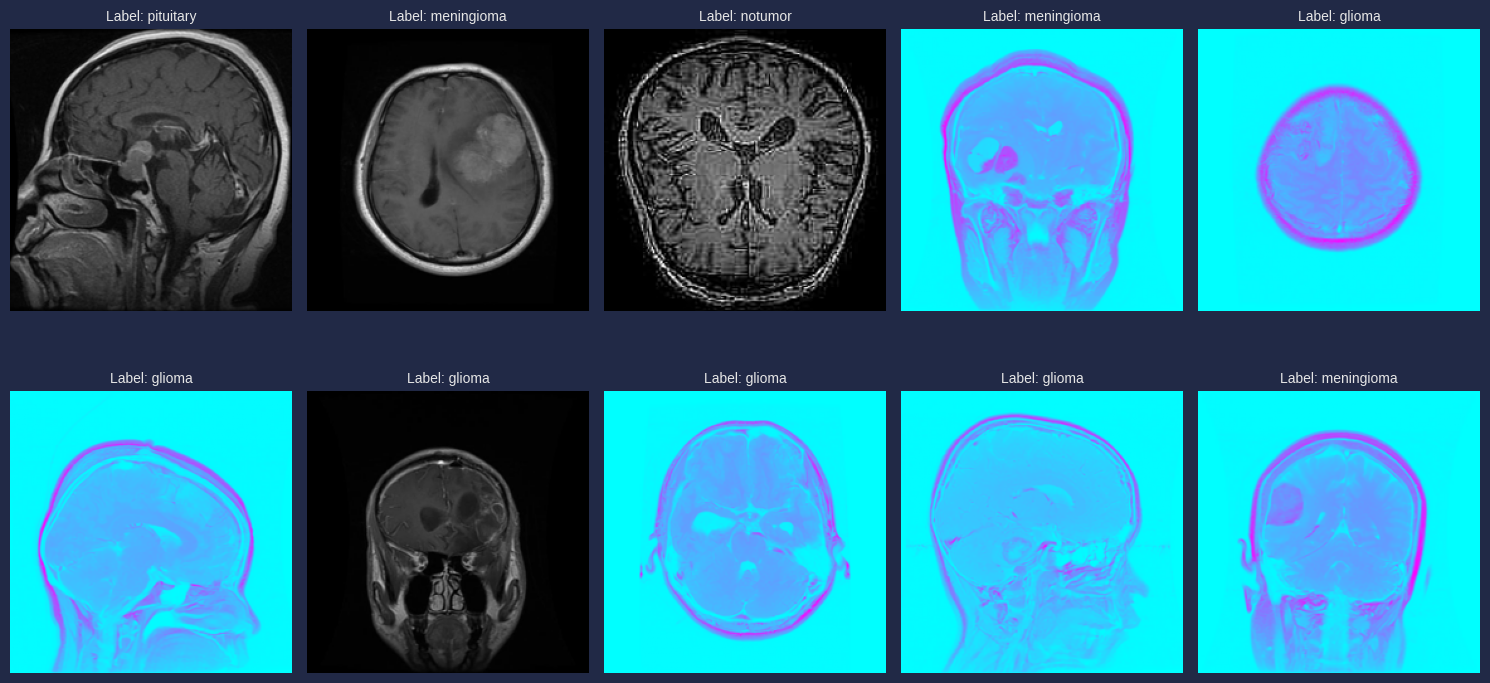

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [6]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

I0000 00:00:1744674844.764779   13045 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1363 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1744674844.766165   13045 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22061 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/5


I0000 00:00:1744674852.161251   13194 service.cc:148] XLA service 0x6ffa680034a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744674852.161278   13194 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1744674852.161282   13194 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-14 19:54:12.185937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744674852.309991   13194 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1744674852.523134   13194 buffer_comparator.cc:157] Difference at 64: 0.972206, expected 2.89127
E0000 00:00:1744674852.523157   13194 buffer_comparator.cc:157] Difference at 65: 0.361239, expected 2.31943
E0000 00:00:1744674852.523159   13194 buffer_comparator.cc:157] Difference at 66: 0.

  9/285 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.7018 - sparse_categorical_accuracy: 0.2259

I0000 00:00:1744674853.915633   13194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.7301
Epoch 2/5


E0000 00:00:1744674858.899938   13194 buffer_comparator.cc:157] Difference at 64: 0, expected 4.79536
E0000 00:00:1744674858.899963   13194 buffer_comparator.cc:157] Difference at 65: 0, expected 5.02506
E0000 00:00:1744674858.899964   13194 buffer_comparator.cc:157] Difference at 66: 0, expected 3.99632
E0000 00:00:1744674858.899966   13194 buffer_comparator.cc:157] Difference at 67: 0, expected 3.95971
E0000 00:00:1744674858.899967   13194 buffer_comparator.cc:157] Difference at 68: 0, expected 5.35184
E0000 00:00:1744674858.899968   13194 buffer_comparator.cc:157] Difference at 69: 0, expected 4.81509
E0000 00:00:1744674858.899969   13194 buffer_comparator.cc:157] Difference at 70: 0, expected 4.45512
E0000 00:00:1744674858.899970   13194 buffer_comparator.cc:157] Difference at 71: 0, expected 5.15239
E0000 00:00:1744674858.899971   13194 buffer_comparator.cc:157] Difference at 72: 0, expected 3.50475
E0000 00:00:1744674858.899972   13194 buffer_comparator.cc:157] Difference at 73: 

285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2782 - sparse_categorical_accuracy: 0.8950
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9450
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9470
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9509


# Train and Val Plots

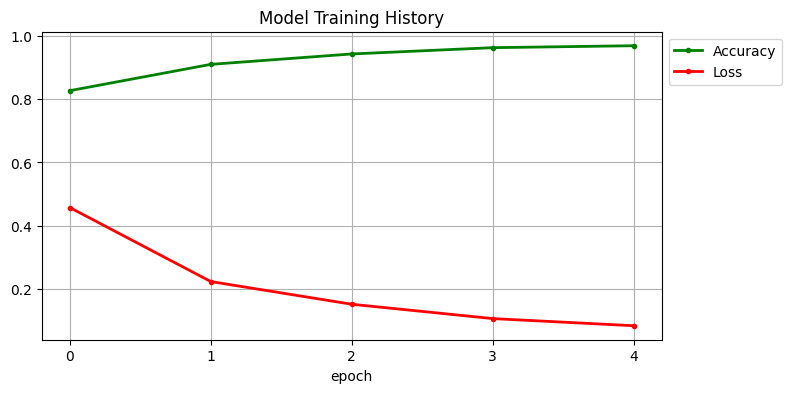

In [7]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


E0000 00:00:1744254546.939691   10610 buffer_comparator.cc:157] Difference at 64: 0, expected 65.5665
E0000 00:00:1744254546.939741   10610 buffer_comparator.cc:157] Difference at 65: 0, expected 66.58
E0000 00:00:1744254546.939744   10610 buffer_comparator.cc:157] Difference at 66: 0, expected 66.6736
E0000 00:00:1744254546.939746   10610 buffer_comparator.cc:157] Difference at 67: 0, expected 70.0884
E0000 00:00:1744254546.939748   10610 buffer_comparator.cc:157] Difference at 68: 0, expected 67.9127
E0000 00:00:1744254546.939750   10610 buffer_comparator.cc:157] Difference at 69: 0, expected 69.0353
E0000 00:00:1744254546.939752   10610 buffer_comparator.cc:157] Difference at 70: 0, expected 70.3397
E0000 00:00:1744254546.939754   10610 buffer_comparator.cc:157] Difference at 71: 0, expected 75.2098
E0000 00:00:1744254546.939756   10610 buffer_comparator.cc:157] Difference at 72: 0, expected 64.8238
E0000 00:00:1744254546.939759   10610 buffer_comparator.cc:157] Difference at 73: 0,

37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

E0000 00:00:1744254549.218655   10611 buffer_comparator.cc:157] Difference at 64: 1.45052, expected 67.4743
E0000 00:00:1744254549.218687   10611 buffer_comparator.cc:157] Difference at 65: 0.127215, expected 67.4581
E0000 00:00:1744254549.218690   10611 buffer_comparator.cc:157] Difference at 66: 1.35202, expected 63.7261
E0000 00:00:1744254549.218693   10611 buffer_comparator.cc:157] Difference at 67: 0.410685, expected 65.4918
E0000 00:00:1744254549.218695   10611 buffer_comparator.cc:157] Difference at 68: 1.56476, expected 72.6543
E0000 00:00:1744254549.218696   10611 buffer_comparator.cc:157] Difference at 69: 0.647422, expected 71.695
E0000 00:00:1744254549.218698   10611 buffer_comparator.cc:157] Difference at 70: 1.18007, expected 70.0257
E0000 00:00:1744254549.218699   10611 buffer_comparator.cc:157] Difference at 71: 0.881744, expected 71.6937
E0000 00:00:1744254549.218701   10611 buffer_comparator.cc:157] Difference at 72: 1.51325, expected 69.4093
E0000 00:00:1744254549.21

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       300
           1       0.97      0.56      0.71       306
           2       0.80      1.00      0.89       300
           3       0.90      1.00      0.95       405

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.87      1311
weighted avg       0.90      0.88      0.87      1311



# Model Confusion Plot

Confusion Matrix:
[[284   6  10   0]
 [ 27 171  65  43]
 [  0   0 299   1]
 [  1   0   0 404]]


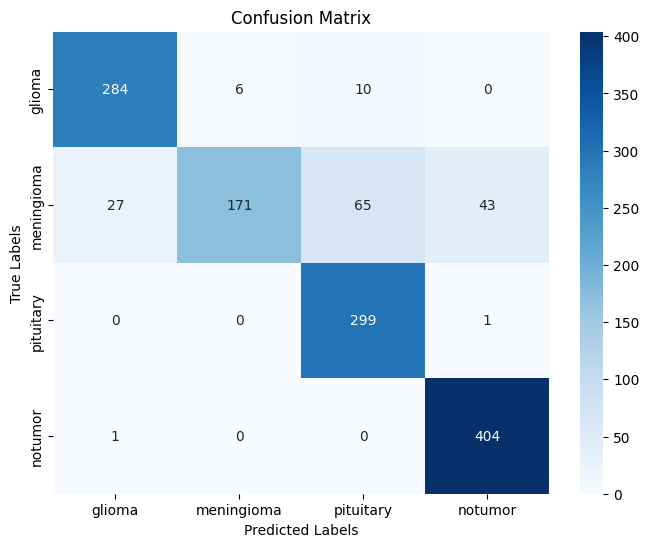

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues_r", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


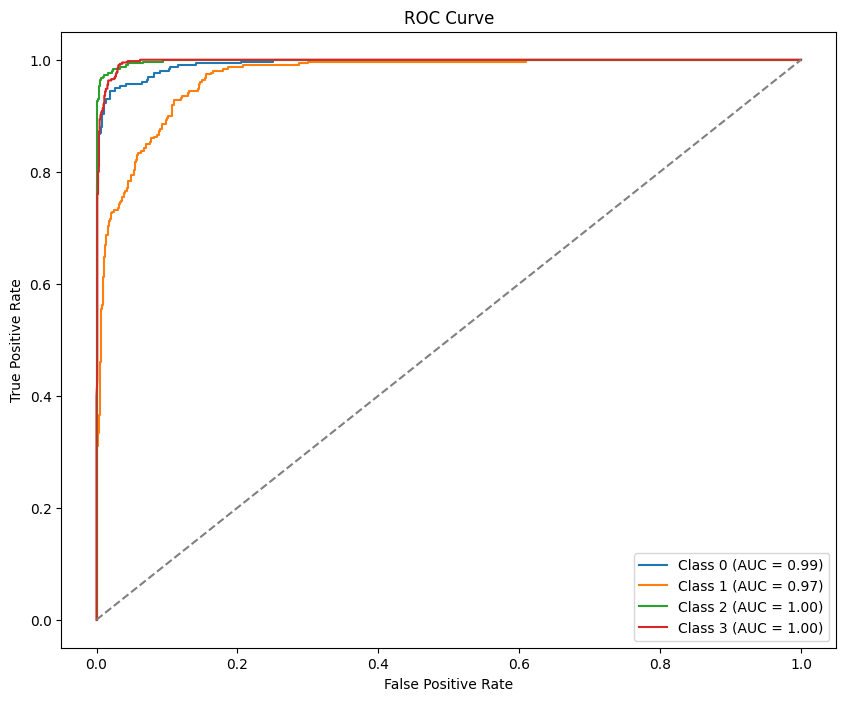

In [11]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [ ]:
# Save the entire model
model.save('checkpoints/vgg16_checkpoint.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('vgg16_checkpoint.h5')

# MRI Tumor Detection System

In [14]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


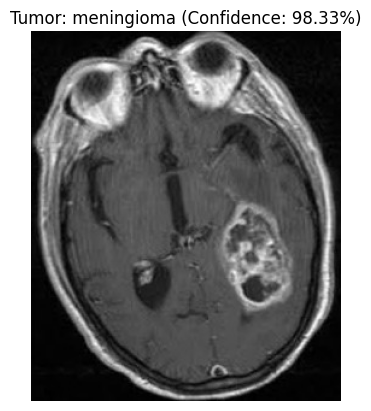

In [15]:
# Example usage
image_path = 'Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


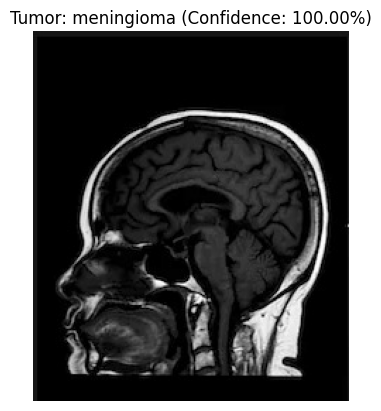

In [16]:

# Example usage
image_path = 'Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


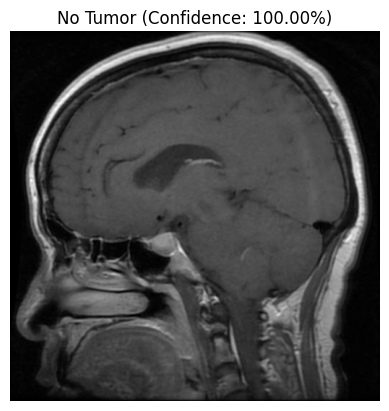

In [17]:
# Example usage
image_path = 'Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


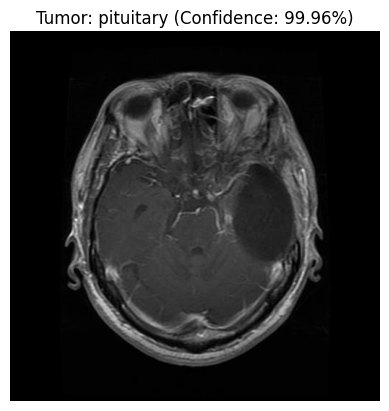

In [18]:
# Example usage
image_path = 'Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)